This notebook is intended to demonstrate how select registration, segmentation, and image mathematical methods of ITKTubeTK can be combined to perform multi-channel brain extraction (aka. skull stripping for patient data containing multiple MRI sequences).

There are many other (probably more effective) brain extraction methods available as open-source software such as BET and BET2 in the FSL package (albeit such methods are only for single channel data).   If you need to perform brain extraction for a large collection of scans that do not contain major pathologies, please use one of those packages.   This notebook is meant to show off the capabilities of specific ITKTubeTK methods, not to demonstration how to "solve" brain extraction.

In [1]:
import itk
from itk import TubeTK as ttk

from itkwidgets import view

import numpy as np

In [2]:
ImageType = itk.Image[itk.F, 3]
ReaderType = itk.ImageFileReader[ImageType]

reader1 = ReaderType.New(FileName="../Data/MRI-Cases/mra.mha")
reader1.Update()
im1 = reader1.GetOutput()

reader2 = ReaderType.New(FileName="../Data/MRI-Cases/mri_t1_sag.mha")
reader2.Update()
im2 = reader2.GetOutput()

reader3 = ReaderType.New(FileName="../Data/MRI-Cases/mri_t2.mha")
reader3.Update()
im3 = reader3.GetOutput()

In [3]:
# Resample data into isotropic voxels and register T1 and T2 with MRA

res = ttk.ResampleImage.New(Input = im1) 
res.SetMakeHighResIso(True)
res.Update()
im1iso = res.GetOutput()

imReg = ttk.RegisterImages[ImageType].New()  # This is the standard protocol for within patient within visit registration
imReg.SetFixedImage(im1iso)
imReg.SetMovingImage(im2)
imReg.SetReportProgress(True)
imReg.SetExpectedOffsetMagnitude(40)
imReg.SetExpectedRotationMagnitude(0.01)
imReg.SetExpectedScaleMagnitude(0.01)
imReg.SetRigidMaxIterations(500)
imReg.SetRigidSamplingRatio(0.1)
imReg.SetRegistration("RIGID")
imReg.SetMetric("MATTES_MI_METRIC")
imReg.Update()
im2iso = imReg.GetFinalMovingImage()

imReg = ttk.RegisterImages[ImageType].New()
imReg.SetFixedImage(im1iso)
imReg.SetMovingImage(im3)
imReg.SetReportProgress(True)
imReg.SetExpectedOffsetMagnitude(40)
imReg.SetExpectedRotationMagnitude(0.01)
imReg.SetExpectedScaleMagnitude(0.01)
imReg.SetRigidMaxIterations(500)
imReg.SetRigidSamplingRatio(0.1)
imReg.SetRegistration("RIGID")
imReg.SetMetric("MATTES_MI_METRIC")
imReg.Update()
im3iso = imReg.GetFinalMovingImage()

itkImageF4 not loaded from module TubeTK because of exception:
 module 'itk.TubeTKPython' has no attribute 'itkImageF4'
vectoritkImageF4 not loaded from module TubeTK because of exception:
 module 'itk.TubeTKPython' has no attribute 'vectoritkImageF4'



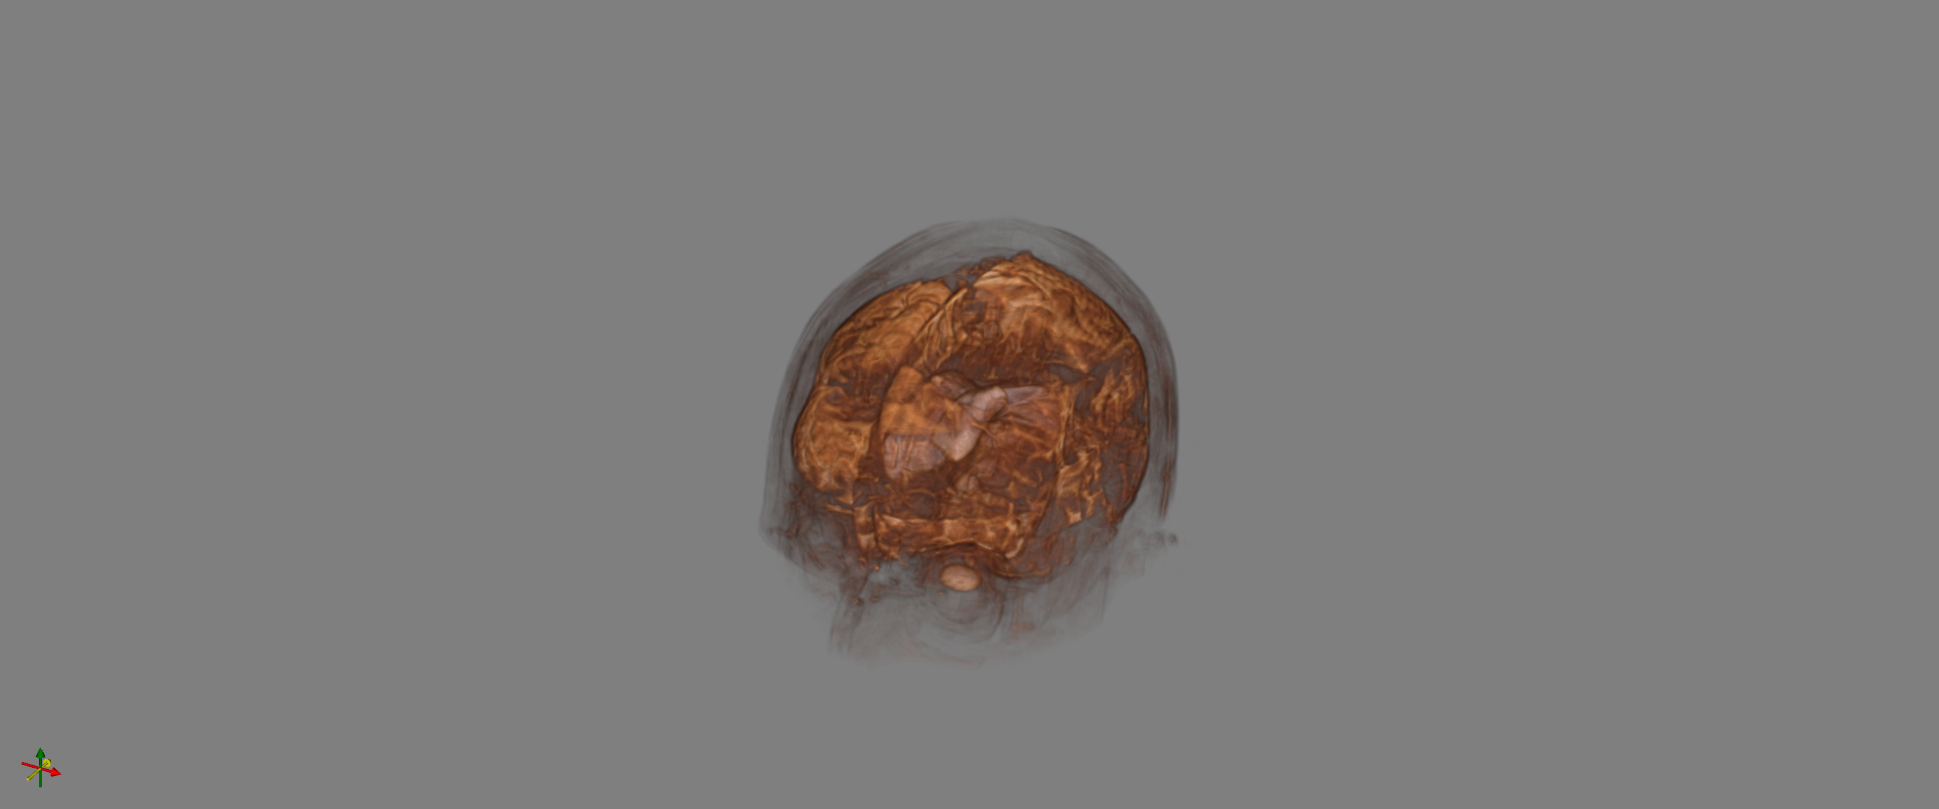
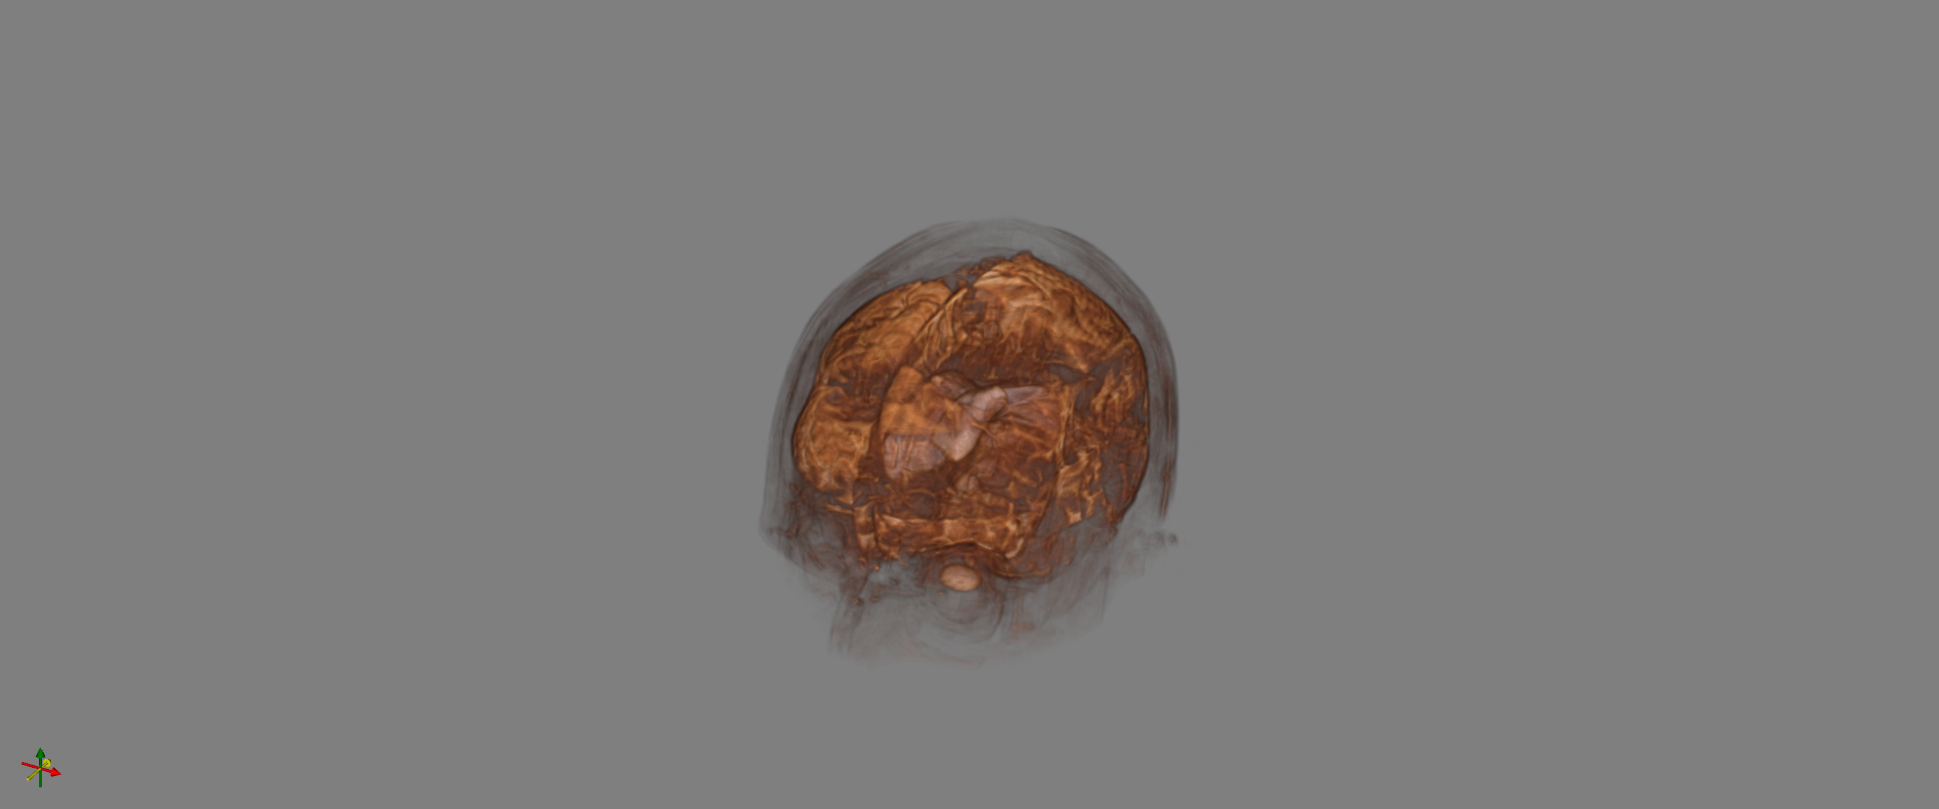

<IPython.core.display.Javascript object>

In [15]:
im23 = itk.CheckerBoardImageFilter(Input1=im2iso, Input2=im3iso)
view(im23)

In [5]:
N = 8
readerList = ["003", "010", "026", "034", "045", "056", "063", "071"]

imBase = []
imBaseB = []
for i in range(0,N):
    name = "../data/MRI-Normals/Normal"+readerList[i]+"-FLASH.mha"
    nameB = "../data/MRI-Normals/Normal"+readerList[i]+"-FLASH-Brain.mha"
    reader = ReaderType.New(FileName=name)
    reader.Update()
    imBaseTmp = reader.GetOutput()
    reader = ReaderType.New(FileName=nameB)
    reader.Update()
    imBaseBTmp = reader.GetOutput()
    imBase.append(imBaseTmp)
    imBaseB.append(imBaseBTmp)

In [6]:
imMath = ttk.ImageMath.New(Input=im2iso)
imMath.Blur(2)
im2isoBlur = imMath.GetOutput()

regB = []
regBB = []
for i in range(0,N):
    imMath.SetInput(imBase[i])
    imMath.Blur(2)
    imBaseBlur = imMath.GetOutput()
    regBTo1 = ttk.RegisterImages[ImageType].New(FixedImage=im2isoBlur, MovingImage=imBaseBlur)
    regBTo1.SetReportProgress(True)
    regBTo1.SetExpectedOffsetMagnitude(40)
    regBTo1.SetExpectedRotationMagnitude(0.01)
    regBTo1.SetExpectedScaleMagnitude(0.1)
    regBTo1.SetRigidMaxIterations(500)
    regBTo1.SetAffineMaxIterations(500)
    regBTo1.SetRigidSamplingRatio(0.05)
    regBTo1.SetAffineSamplingRatio(0.05)
    regBTo1.SetInitialMethodEnum("INIT_WITH_IMAGE_CENTERS")
    regBTo1.SetRegistration("PIPELINE_AFFINE")
    regBTo1.SetMetric("MATTES_MI_METRIC")
    #regBTo1.SetMetric("NORMALIZED_CORRELATION_METRIC") - Really slow!
    #regBTo1.SetMetric("MEAN_SQUARED_ERROR_METRIC")
    regBTo1.Update()
    img = regBTo1.ResampleImage("LINEAR", imBase[i])
    regB.append( img )
    img = regBTo1.ResampleImage("LINEAR", imBaseB[i])
    regBB.append( img )


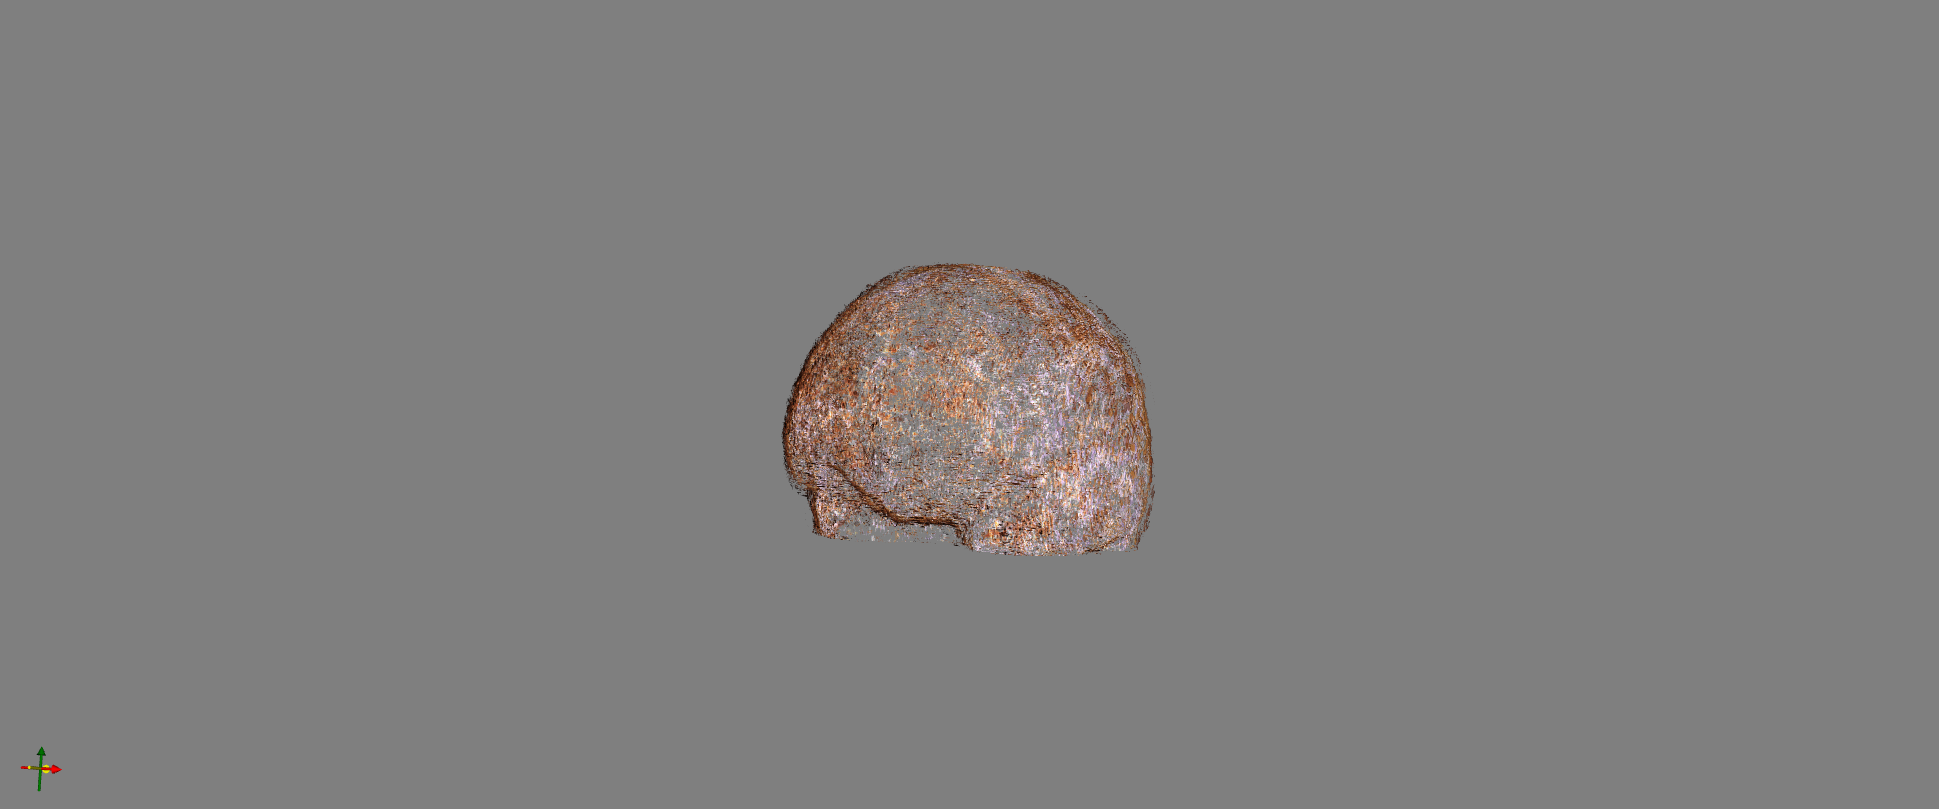
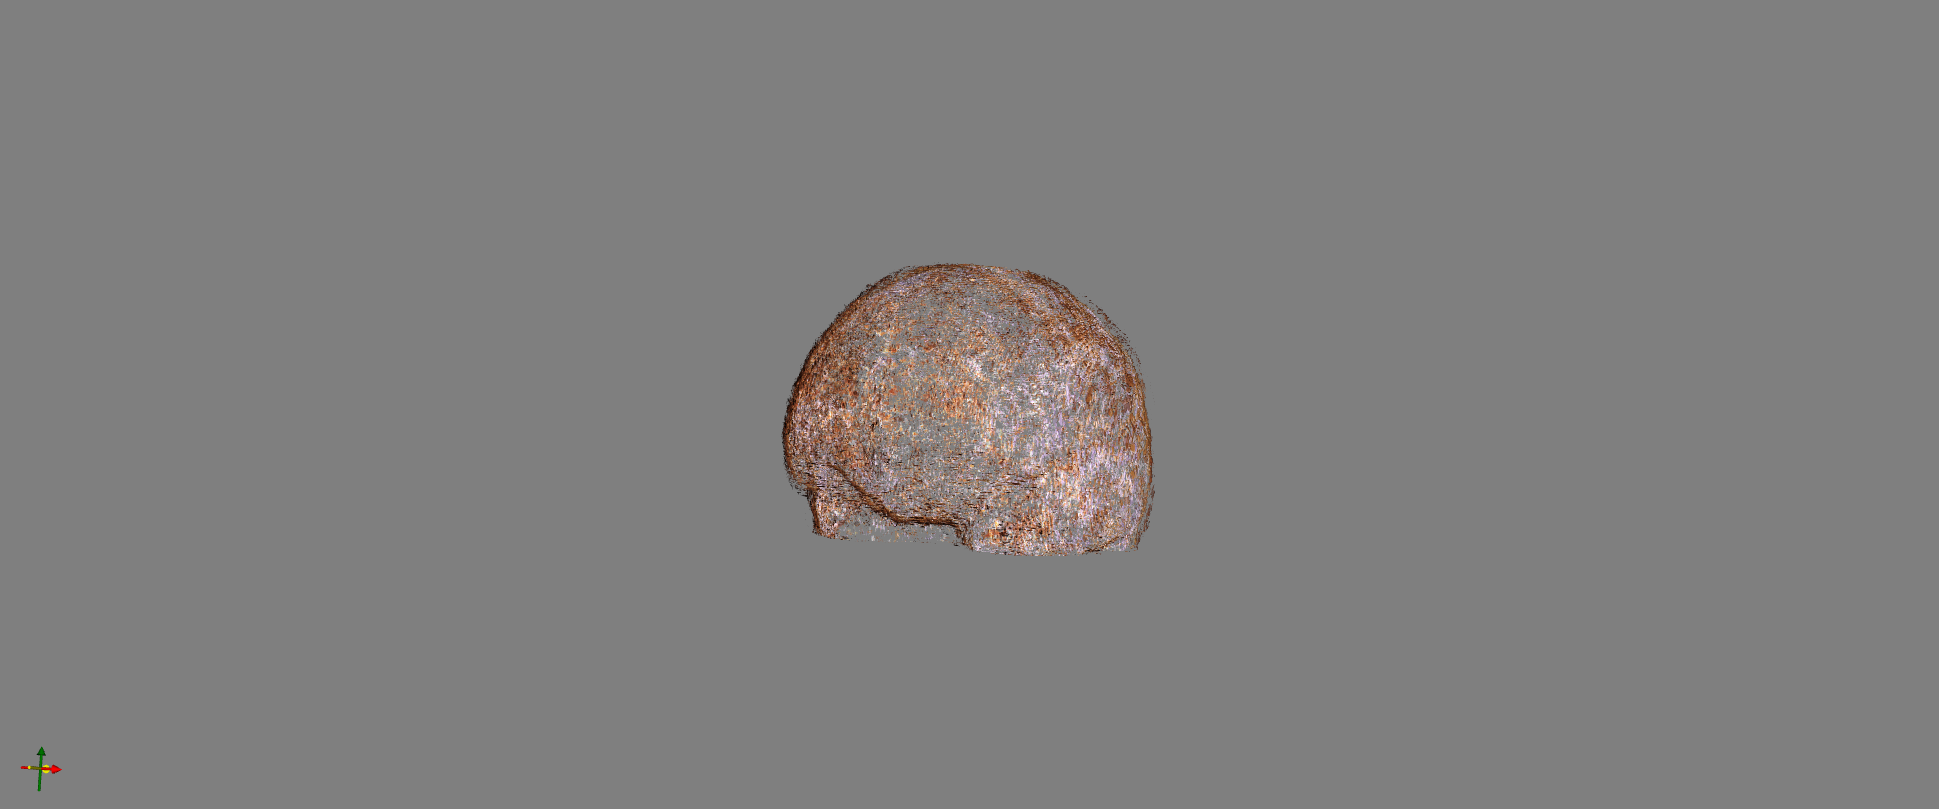

<IPython.core.display.Javascript object>

In [8]:
regBBT = []
for i in range(0,N):
    imMath = ttk.ImageMath.New( Input=regBB[i] )
    imMath.Threshold(0,1,0,1)
    img = imMath.GetOutput()
    if i==0:
        imMathSum = ttk.ImageMath.New( img )
        imMathSum.AddImages( img, 1.0/N, 0 )
        sumBBT = imMathSum.GetOutput()
    else:
        imMathSum = ttk.ImageMath.New( sumBBT )
        imMathSum.AddImages( img, 1, 1.0/N )
        sumBBT = imMathSum.GetOutput()
        
view(sumBBT)


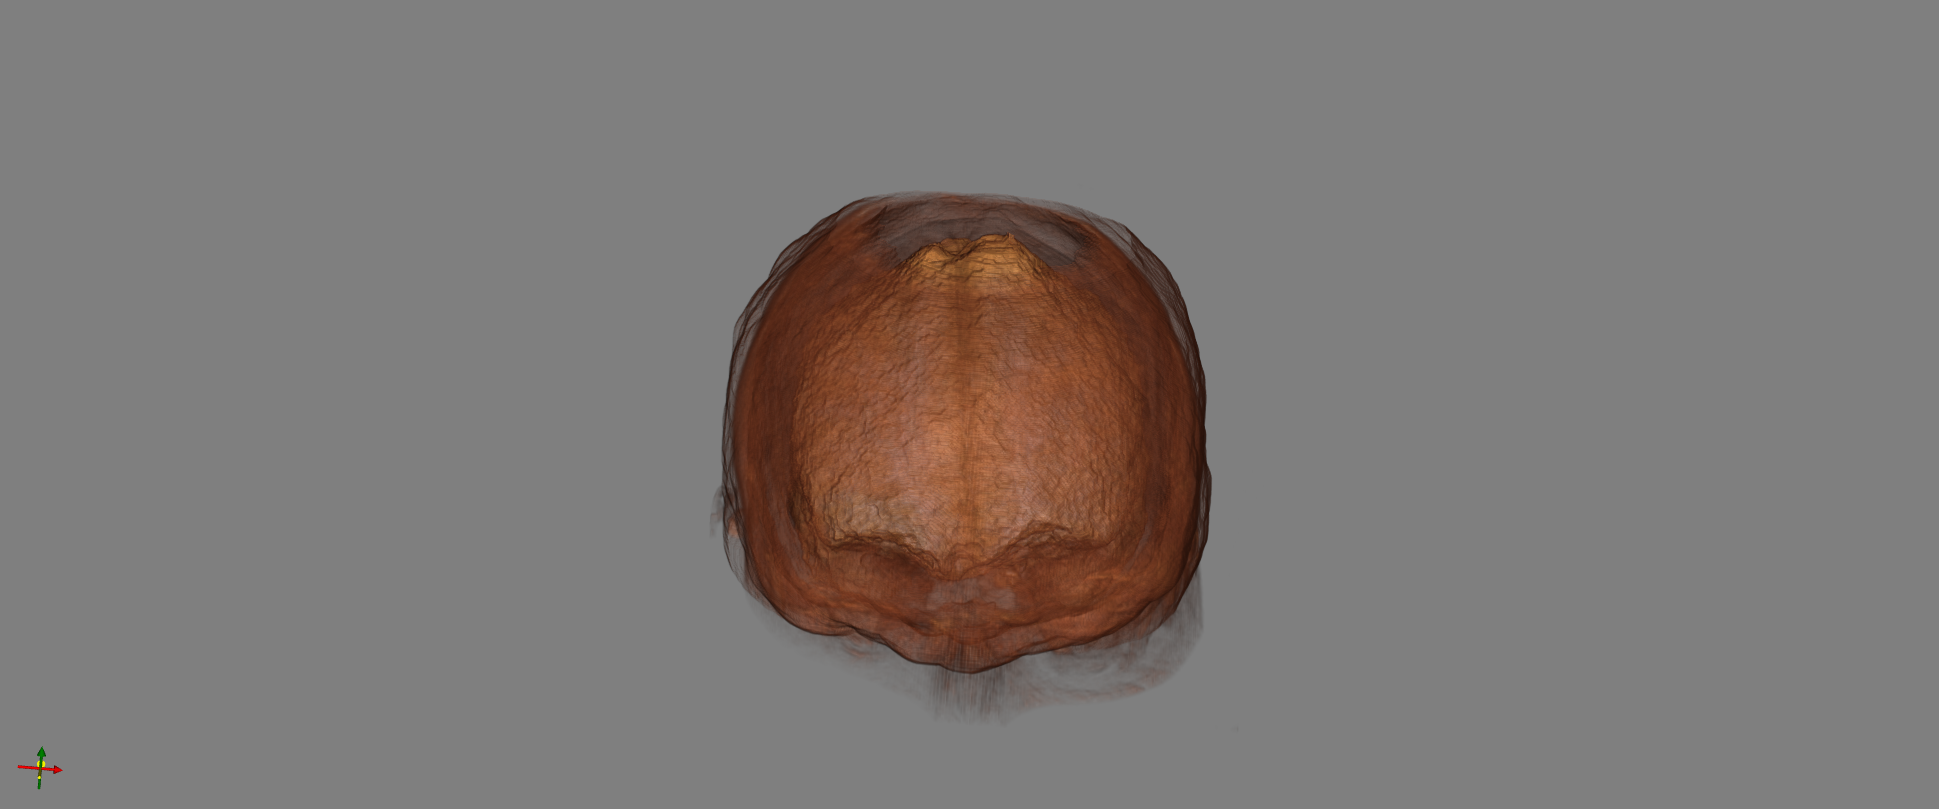
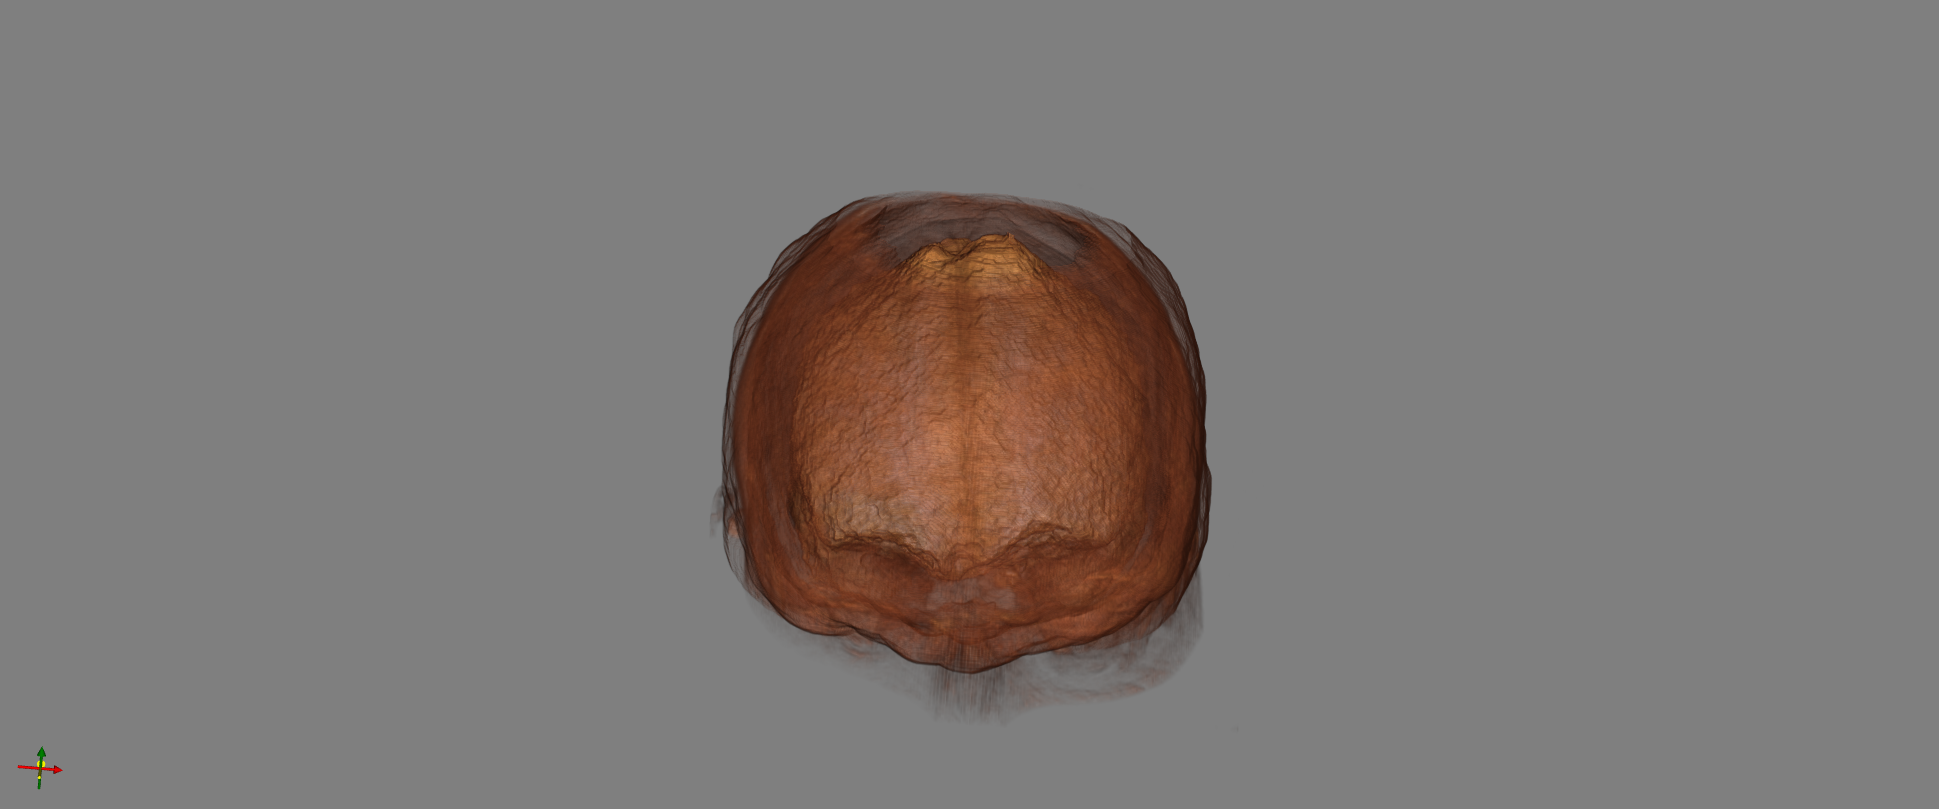

<IPython.core.display.Javascript object>

In [9]:
insideMath = ttk.ImageMath.New( Input = sumBBT )
insideMath.Threshold(1,1,1,0)
insideMath.Erode(5,1,0)
brainInside = insideMath.GetOutput()

outsideMath = ttk.ImageMath.New( Input = sumBBT )
outsideMath.Threshold(0,0,1,0)
outsideMath.Erode(10,1,0)
brainOutsideAll = outsideMath.GetOutput()
outsideMath.Erode(20,1,0)
outsideMath.AddImages(brainOutsideAll, -1, 1)
brainOutside = outsideMath.GetOutput()

outsideMath.AddImages(brainInside,1,2)
brainCombinedMask = outsideMath.GetOutputUChar()

outsideMath.AddImages(im2iso, 512, 1)
brainCombinedMaskView = outsideMath.GetOutput()
view(brainCombinedMaskView)

In [10]:
LabelMapType = itk.Image[itk.UC,3]

segmenter = ttk.SegmentConnectedComponentsUsingParzenPDFs[ImageType,LabelMapType].New()
segmenter.SetFeatureImage( im1iso )
segmenter.AddFeatureImage( im2iso )
segmenter.AddFeatureImage( im3iso )
segmenter.SetInputLabelMap( brainCombinedMask )
segmenter.SetObjectId( 2 )
segmenter.AddObjectId( 1 )
segmenter.SetVoidId( 0 )
segmenter.SetErodeDilateRadius( 5 )
segmenter.Update()
segmenter.ClassifyImages()
brainCombinedMaskClassified = segmenter.GetOutputLabelMap()

In [12]:
cast = itk.CastImageFilter[LabelMapType, ImageType].New()
cast.SetInput(brainCombinedMaskClassified)
cast.Update()
brainMaskF = cast.GetOutput()

brainMath = ttk.ImageMath.New(Input = brainMaskF)
brainMath.Threshold(2,2,1,0)
brainMath.Dilate(2,1,0)
brainMaskD = brainMath.GetOutput()
brainMath.SetInput( im1 )
brainMath.ReplaceValuesOutsideMaskRange( brainMaskD, 1, 1, 0)
brain = brainMath.GetOutput()


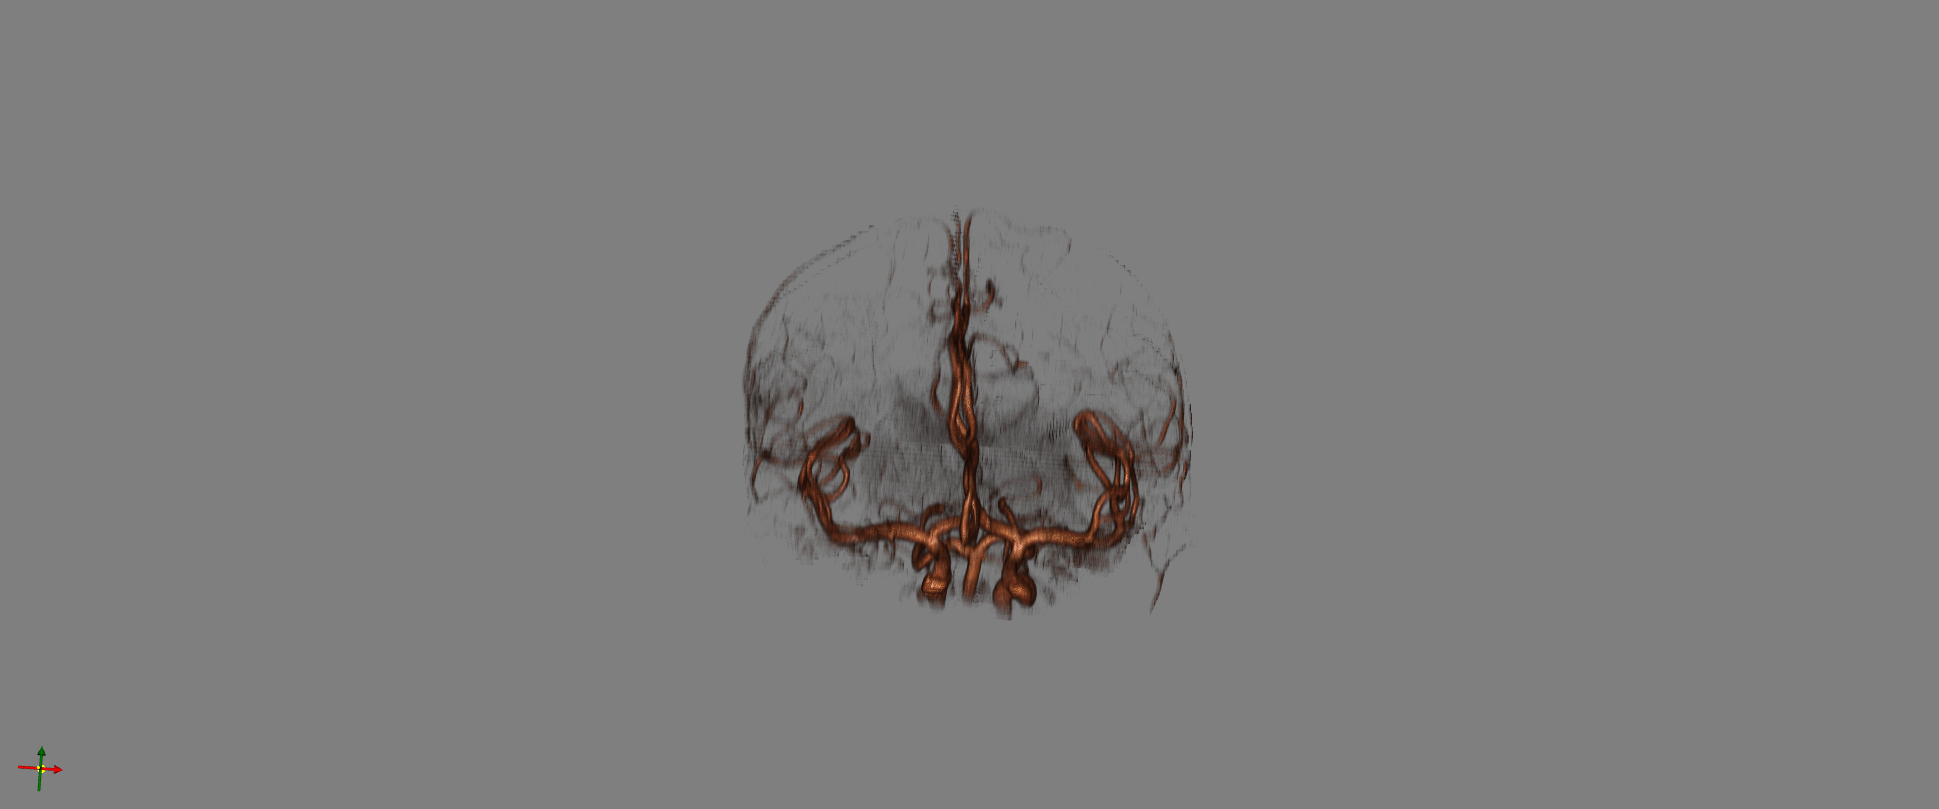
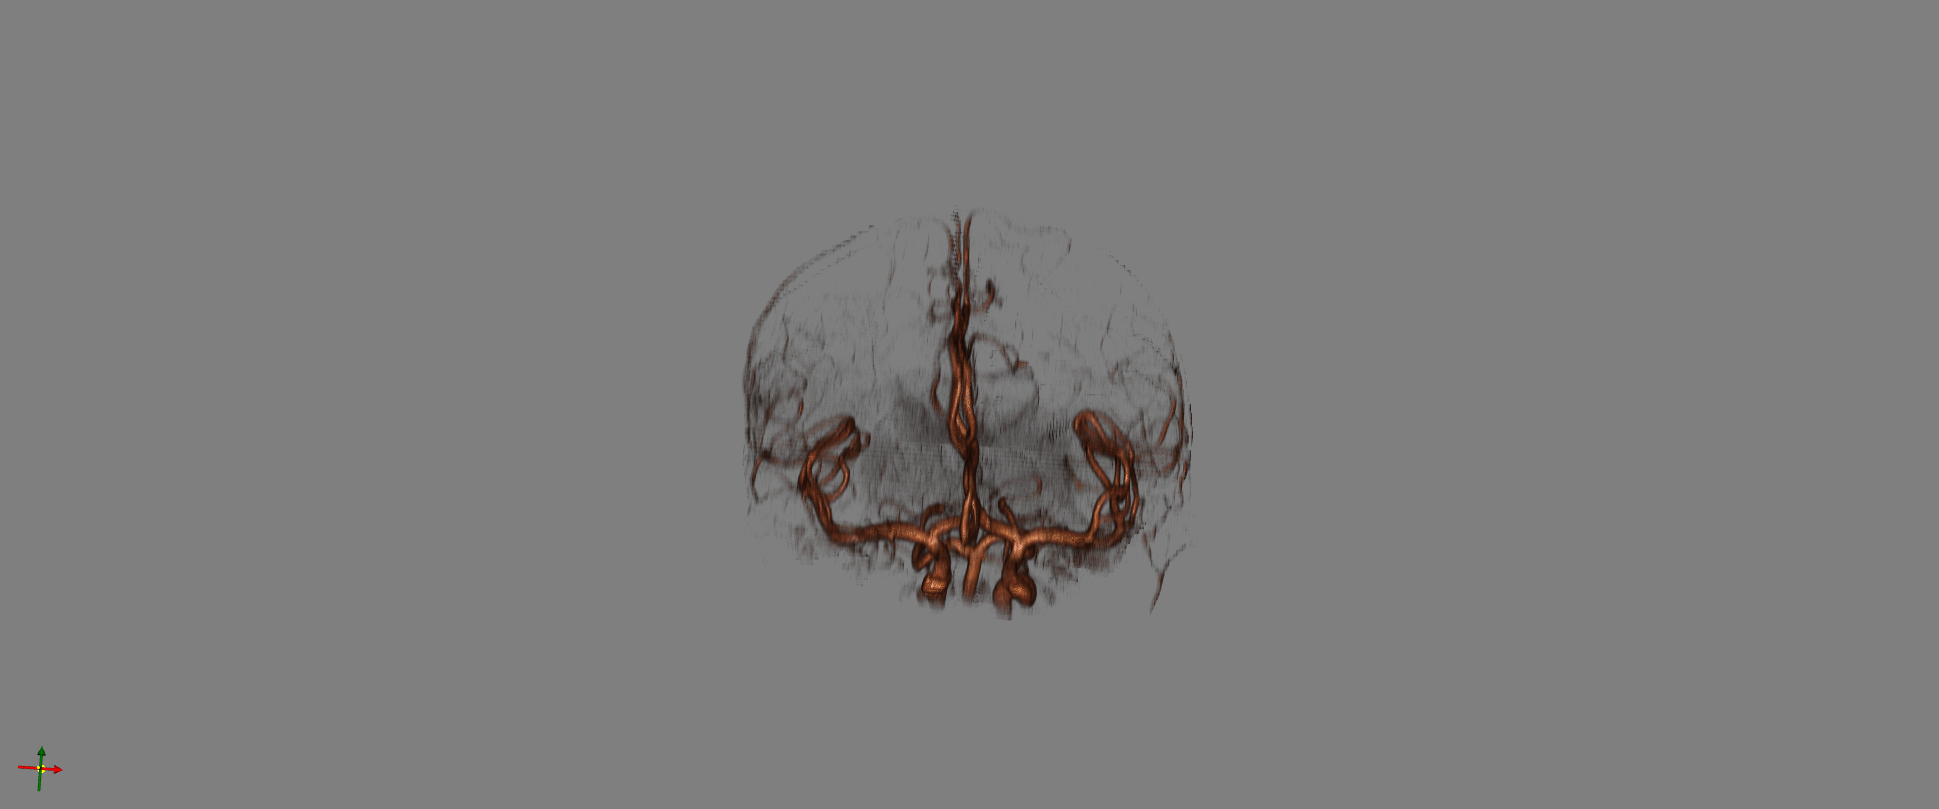

<IPython.core.display.Javascript object>

In [13]:
view(brain)

In [14]:
itk.imwrite(brainMaskD, "MRMask-Brain.mha")

itk.imwrite(im1iso, "MRA-Iso.mha")
itk.imwrite(im2iso, "MRT1-Iso.mha")
itk.imwrite(im3iso, "MRT2-Iso.mha")

itk.imwrite(brain, "MRA-Brain.mha")

brainMath.SetInput(im2iso)
brainMath.ReplaceValuesOutsideMaskRange( brainMaskD, 1, 1, 0 )
itk.imwrite(brainMath.GetOutput(), "MRT1-Brain.mha")

brainMath.SetInput(im3iso)
brainMath.ReplaceValuesOutsideMaskRange( brainMaskD, 1, 1, 0 )
itk.imwrite(brainMath.GetOutput(), "MRT2-Brain.mha")